In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetB3
from keras import layers

In [2]:
import utils

In [3]:
import dataset
dataset = dataset.Dataset()

In [6]:
DATAPATH = 'data/'
IMG_SIZE = 224 
SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 32
LABELS = dataset.getLabelList()
# change labels = LABELS for regression
(train_set, test_set) = tf.keras.utils.image_dataset_from_directory(
    DATAPATH,
    image_size = SIZE,
    batch_size = BATCH_SIZE,
    labels = LABELS,
    label_mode = 'int',
    color_mode = 'grayscale',
    validation_split = 0.2,
    subset = 'both',
    seed = 1234,
)

[350, 350, 89, 89, -421, -421, -300, -300, -2100, -2100, 1555, 1555, -977, -977, 1824, 1824, 150, 150, 1846, 1846, 1700, 1700, -455, -455, 438, 438, 570, 570, 1779, 1779, 17, 17, 486, 486, -768, -768, -440, -440, -3500, -3500, -900, -900, 1861, 1861, 1810, 1810, 1657, 1657, -1150, -1150, 1550, 1550, 1855, 1855, 300, 300, 1150, 1150, 1800, 1800, -600, -600, 1350, 1350, -1977, -1977, -50, -50, 1887, 1887, 1908, 1908, 1650, 1650, -250, -250, -504, -504, 1850, 1850, -250, -250, 1150, 1150, 1890, 1890, 200, 200, -400, -400, 781, 781, -500, -500, -300, -300, 195, 195, -675, -675, 1800, 1800, 1476, 1476, -1436, -1436, 16, 16, 1853, 1853, 750, 750, 523, 523, 850, 850, -1344, -1344, 1848, 1848, 1361, 1361, -400, -400, 1775, 1775, 1845, 1845, 400, 400, 1882, 1882, 700, 700, -1859, -1859, 763, 763, -350, -350, -2300, -2300, 1150, 1150, 1550, 1550, 1175, 1175, -10, -10, 1550, 1550, -560, -560, 1900, 1900, -1246, -1246, 1845, 1845, 300, 300, -637, -637, -264850, -264850, 650, 650, -360, -360, -350,

In [7]:
print(train_set.class_names)
num_classes = len(train_set.class_names)
num_classes

[-264850, -244950, -94950, -19988, -7000, -6977, -3500, -3000, -2977, -2900, -2750, -2596, -2560, -2550, -2500, -2450, -2400, -2387, -2375, -2360, -2352, -2332, -2300, -2290, -2282, -2236, -2200, -2195, -2100, -2000, -1980, -1977, -1919, -1903, -1900, -1891, -1860, -1859, -1800, -1781, -1750, -1725, -1700, -1600, -1550, -1500, -1478, -1468, -1436, -1422, -1410, -1391, -1371, -1363, -1350, -1344, -1329, -1325, -1323, -1309, -1300, -1287, -1279, -1270, -1250, -1246, -1235, -1225, -1177, -1150, -1129, -1125, -1115, -1100, -1001, -1000, -990, -977, -969, -908, -903, -900, -858, -850, -829, -800, -772, -768, -750, -730, -700, -688, -677, -675, -650, -645, -643, -640, -637, -626, -605, -600, -583, -580, -560, -550, -540, -537, -520, -510, -504, -500, -490, -487, -476, -475, -465, -460, -455, -450, -440, -435, -425, -421, -400, -361, -360, -350, -348, -347, -332, -325, -312, -300, -277, -273, -260, -250, -230, -209, -200, -195, -191, -186, -184, -160, -150, -120, -100, -50, -46, -40, -27, -26

420

EfficientNet3 with Sparse Categorical Crossentropy

In [ ]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=augmented, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    layer3 = layers.Dense(units = 2048)(dropout)
    layer2 = layers.Dense(units = 1024)(layer3)
    layer1 = layers.Dense(units = 512)(layer2)
    outputs = layers.Dense(num_classes, activation="softmax")(layer1)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

EfficientNet3 with Mean Absolute Error

In [6]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    outputs = layers.Dense(units = 1)(dropout)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=["mean_absolute_error"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


EfficientNetB3 with MAE, larger fully connected layer

In [11]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    layer3 = layers.Dense(units = 512)(dropout)
    layer2 = layers.Dense(units = 256)(layer3)
    layer1 = layers.Dense(units = 64)(layer2)
    outputs = layers.Dense(units = 1)(layer1)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=["mean_absolute_error"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model from [this](https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow) StackOverflow post. <br>
This uses a regression model.

In [7]:
augmentation_layer = tf.keras.Sequential([                                    
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
], name='data_augmentation')  

model = tf.keras.Sequential([
    augmentation_layer,
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss='mean_absolute_error', optimizer="adam", metrics=['mean_absolute_error'])

Network from [This](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) paper _without_ multi GPU: <br>
5 Conv layers followed by 3 fully connected layers. Afer each fully connected layer, a ReLu unit is used as nonlinearity. Additionally normalization and dropout are applied 
(found via [Image Orientation Estimation with Convolutional Networks](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf)). <br>
**Not Implemented**: 
- Multiple GPUs
- First Layers with Stride of 4

Other hyper parameters to change: 
- Batch size of 128
- 90 cycles through the training set

In [52]:
callbacks = [ tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)] # Paper does not specify the patience, so I chose 5
optimizer = tf.keras.optimizers.experimental.SGD(weight_decay=0.0005, learning_rate=0.01, momentum=0.9)

one_bias_initializer = tf.keras.initializers.Constant(value=1)
zero_bias_initializer = tf.keras.initializers.Constant(value=0)

KrizhevskyModel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(5, 5, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=zero_bias_initializer),
    tf.keras.layers.Lambda(lambda input: tf.nn.local_response_normalization(input=input, alpha=0.0001, beta=0.75, depth_radius=5, bias=2.0)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Lambda(lambda input: tf.nn.local_response_normalization(input=input, alpha=0.0001, beta=0.75, depth_radius=5, bias=2.0)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=zero_bias_initializer),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=4096, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
])

KrizhevskyModel.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [9]:
EPOCHS = 30

EfficientNet

In [12]:
histEfficientNet = modelEfficientNet.fit(train_set, epochs=EPOCHS, validation_data=test_set) 

Epoch 1/30
41/41 [==============================] - 247s 5s/step - loss: 1422.3597 - mean_absolute_error: 1422.3597 - val_loss: 3455.7415 - val_mean_absolute_error: 3455.7415
Epoch 2/30
41/41 [==============================] - 218s 5s/step - loss: 1362.5571 - mean_absolute_error: 1362.5571 - val_loss: 3514.2341 - val_mean_absolute_error: 3514.2341
Epoch 3/30
41/41 [==============================] - 216s 5s/step - loss: 1306.3922 - mean_absolute_error: 1306.3922 - val_loss: 3437.4441 - val_mean_absolute_error: 3437.4441
Epoch 4/30
41/41 [==============================] - 216s 5s/step - loss: 1229.7406 - mean_absolute_error: 1229.7406 - val_loss: 4255.5752 - val_mean_absolute_error: 4255.5752
Epoch 5/30
41/41 [==============================] - 216s 5s/step - loss: 1194.4930 - mean_absolute_error: 1194.4930 - val_loss: 3487.7485 - val_mean_absolute_error: 3487.7485
Epoch 6/30
41/41 [==============================] - 216s 5s/step - loss: 1132.8090 - mean_absolute_error: 1132.8090 - val_los

Model

In [10]:
histModel = model.fit(train_set, epochs=EPOCHS, validation_data=test_set)

Epoch 1/30


41/41 [==============================] - 11s 223ms/step - loss: 1417.5435 - mean_absolute_error: 1417.5435 - val_loss: 3428.3430 - val_mean_absolute_error: 3428.3430
Epoch 2/30
41/41 [==============================] - 9s 216ms/step - loss: 1394.9926 - mean_absolute_error: 1394.9926 - val_loss: 3420.0232 - val_mean_absolute_error: 3420.0232
Epoch 3/30
41/41 [==============================] - 9s 215ms/step - loss: 1386.3599 - mean_absolute_error: 1386.3599 - val_loss: 3428.5645 - val_mean_absolute_error: 3428.5645
Epoch 4/30
41/41 [==============================] - 9s 217ms/step - loss: 1384.0984 - mean_absolute_error: 1384.0984 - val_loss: 3440.1494 - val_mean_absolute_error: 3440.1494
Epoch 5/30
41/41 [==============================] - 10s 232ms/step - loss: 1394.3147 - mean_absolute_error: 1394.3147 - val_loss: 3427.6338 - val_mean_absolute_error: 3427.6338
Epoch 6/30
41/41 [==============================] - 9s 219ms/step - loss: 1368.4308 - mean_absolute_error: 1368.4308 - val_loss: 

Krizhevsky

In [ ]:
histKrizhevsky = KrizhevskyModel.fit(train_set, epochs=EPOCHS, validation_data=test_set, callbacks=callbacks)

AutoKeras from [this](https://autokeras.com/tutorial/image_regression/) tutorial

In [13]:
import autokeras as ak

reg = ak.ImageRegressor(overwrite=True, max_trials=5, loss="mean_absolute_error", metrics=["mean_absolute_error"])
reg.fit(train_set, epochs=10)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
False             |False             |image_block_1/normalize
False             |False             |image_block_1/augment
resnet            |resnet            |image_block_1/block_type
False             |False             |image_block_1/res_net_block_1/pretrained
resnet50          |resnet50          |image_block_1/res_net_block_1/version
False             |False             |image_block_1/res_net_block_1/imagenet_size
0.25              |0.25              |regression_head_1/dropout
adam              |adam              |optimizer
0.001             |0.001             |learning_rate

Epoch 1/10
33/33 [==============================] - 170s 5s/step - loss: 1461.0618 - mean_absolute_error: 1461.0618 - val_loss: 1650.1598 - val_mean_absolute_error: 1650.1598
Epoch 2/10
15/33 [============>.................] - ETA: 1:15 - loss: 1460.3790 - mean_absolute_error: 1460.3790

KeyboardInterrupt: 

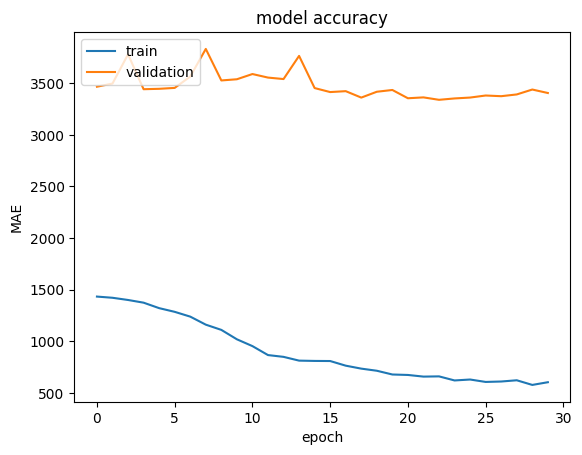

In [11]:
utils.plot_accuracy(histEfficientNet, "mean_absolute_error", "EfficientNetB3")

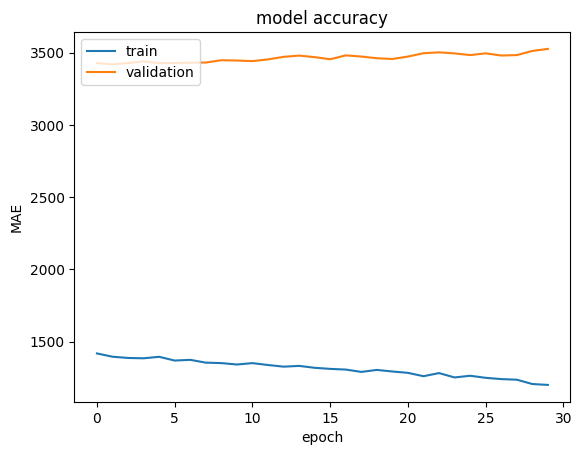

In [12]:
utils.plot_accuracy(histModel, "mean_absolute_error", "Model1")

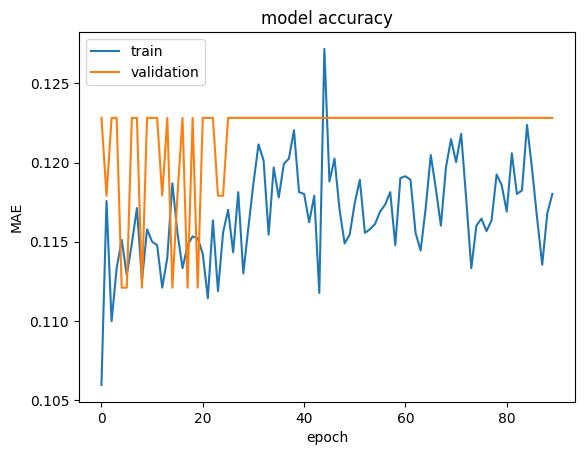

In [55]:
utils.plot_accuracy(histKrizhevsky, "accuracy", "Krizhevsky")